<a href="https://colab.research.google.com/github/ed-ntim/D2/blob/master/08_representations_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PROPERTIES AND EXPLORATION OF HIDDEN *REPRESENTATIONS*


MAIN OBJECTIVES:
- extract hidden representation customising a standard model
- discuss qualitatively few basic techniques for analysis of *representations*

We set up the basics for training the models we are going to inspect later:

- we make sure folders in the course repo are available;
- we load the MNIST dataset and check the data looks as expected;
- we define basic training and test functionalities we will use for learning the weights of our model
- we define standard training hyperparameters

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/PROVA

In [1]:
# basic imports, load MNIST
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')


minibatch_size_train = 64
minibatch_size_test = 1000

In [2]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size_test, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 77194908.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80169221.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 149548954.41it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17131770.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



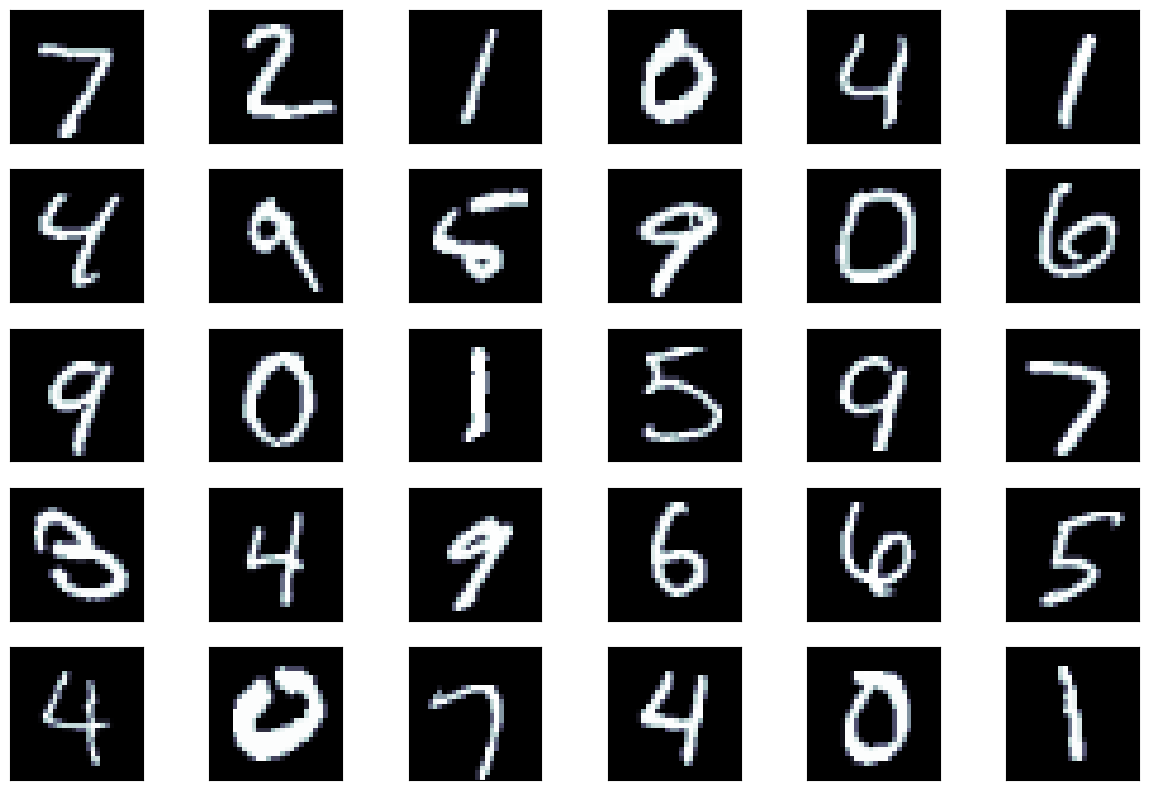

In [3]:
# a quick look at MNIST images
inputs,labels = next(iter(testloader))

fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

In [4]:
#make sure we handle correctly hardware resources depending on availability, and fix seed
use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

In [5]:
#fix basic training settings, and fix seed. NOTE: modify as you please!
seed = 33
torch.manual_seed(seed)
input_size=(1,28,28,)
epochs=5
lr=0.01
momentum=0.0
log_interval=100

In [6]:
#set up basic train and test functionalities
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
#define convolutional network with
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = ConvNet().to(device)
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [9]:
model.eval()
output = model(inputs.to(device))
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(labels.to(device).view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.084


In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=True

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

if save:
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.326957
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.980593
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.819767
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.507210
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380899
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.507126
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.158108
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.234380
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.275566
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.198847

Test set: Average loss: 0.2058, Accuracy: 9313/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.182679
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.078124
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.140805
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.190516
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.124825
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.066523
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.242583
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.082794
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.060046
T

Exercise 1: Basics.
- Define a model ConvNetReps with an additional attribute to extract the hidden representations of the model ConvNet.
- Define an instance of ConvNetReps and load weights obtained from training of ConvNet
- Extract representations for a batch of the testloader, and inspect dimensions

In [12]:
from torchvision.datasets.mnist import read_sn3_pascalvincent_tensor
#define convolutional network with extract method
class ConvNetReps(nn.Module):
    def __init__(self):
        super(ConvNetReps, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def extract(self, x):
        r1 = F.relu(self.conv1(x))
        r2 = F.max_pool2d(r1, 2, 2)
        r3 = F.relu(self.conv2(r2))
        r4 = F.max_pool2d(r3, 2, 2)
        r4 = r4.view(-1, 4*4*50)
        r5 = F.relu(self.fc1(r4))
        r6 = self.fc2(r5)
        return r1, r2, r3, r4 ,r5, r6

In [13]:
#define instance of ConvNetReps(), load weights, set in evaluation mode
model = ConvNetReps()

In [14]:
model.load_state_dict(torch.load('mnist_cnn.pt'))

<All keys matched successfully>

In [15]:
#load a batch of inputs from the testloader
#extract representations using method defined above
#inspect dimensions
x, y = next(iter(testloader))

In [16]:
x.shape, y.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

In [17]:
r1, r2, r3, r4, r5, r6 = model.extract(x)

In [18]:
r1.size(), r2.size(), r3.size(), r4.size(), r5.size(), r6.size()

(torch.Size([1000, 20, 24, 24]),
 torch.Size([1000, 20, 12, 12]),
 torch.Size([1000, 50, 8, 8]),
 torch.Size([1000, 800]),
 torch.Size([1000, 500]),
 torch.Size([1000, 10]))

Exercise 2: Visualisation.

Note that after each convolution each channel can be interpreted as an image.
- Choose an image and plot the first 20 channels for the first 4 layers. What does it show about the level of abstraction?

"T-distributed Stochastic Neighbor Embedding" [TSNE-sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) allows to project high dimensional data onto 2-d allowing simple visualisation that preserves some of the properties of the original data.
- Use TSNE to inspect the geometry of some layers (e.g. layers after second maxpooling, two last hidden layers).

- Take home message &/or reading exercise: TSNE has strenght and limitations [Distill-TSNE](https://distill.pub/2016/misread-tsne/)

Another popular tool for visualisation is "Uniform Manifold Approximation and Projection" [UMAP](https://umap-learn.readthedocs.io/en/latest/), and you can more read about the two here [TSNEvsUMAP](https://pair-code.github.io/understanding-umap/)

In [19]:
r1 = r1.detach().numpy()
r2 = r2.detach().numpy()
r3 = r3.detach().numpy()
r4 = r4.view(-1,50,4,4)
r4 = r4.detach().numpy()
r5 = r5.view(-1,50,4,4)
r5 = r5.detach().numpy()
# r6 = r6.view(-1,50,4,4)
# r6 = r6.detach().numpy()

In [20]:
r1.shape, r2.shape, r3.shape, r4.shape, r5.shape, r6.shape

((1000, 20, 24, 24),
 (1000, 20, 12, 12),
 (1000, 50, 8, 8),
 (1000, 50, 4, 4),
 (625, 50, 4, 4),
 torch.Size([1000, 10]))

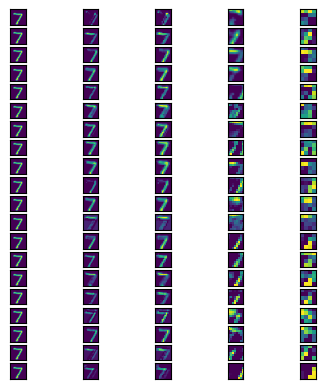

In [22]:
# Choose an image and plot the first 20 Channels for the first 4 layers
from matplotlib import pyplot as plt

for i in range(20):
    x_i=x[0,0,::].detach().numpy() #first image
    a = r1[0,i,::]
    b = r2[0,i,::]
    c = r3[0,i,::]
    d = r4[0,i,::]
    # e = r5[0,i,::]
    # f = r6[::]


    plt.subplot(20,7,7*(i)+1)
    plt.imshow(x_i)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(20,7,7*(i)+2)
    plt.imshow(a)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(20,7,7*(i)+3)
    plt.imshow(b)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(20,7,7*(i)+4)
    plt.imshow(c)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(20,7,7*(i)+5)
    plt.imshow(d)
    plt.xticks([])
    plt.yticks([])

    # plt.subplot(20,7,7*(i)+6)
    # plt.imshow(e)
    # plt.xticks([])
    # plt.yticks([])

    # plt.subplot(20,7,7*(i)+7)
    # plt.imshow(f)
    # plt.xticks([])
    # plt.yticks([])




In [23]:
r1, r2, r3, r4, r5, r6 = model.extract(x)
r1 = r1.detach().numpy()
r2 = r2.detach().numpy()
r3 = r3.detach().numpy()
r4 = r4.detach().numpy()
r5 = r5.detach().numpy()
r6 = r6.detach().numpy()

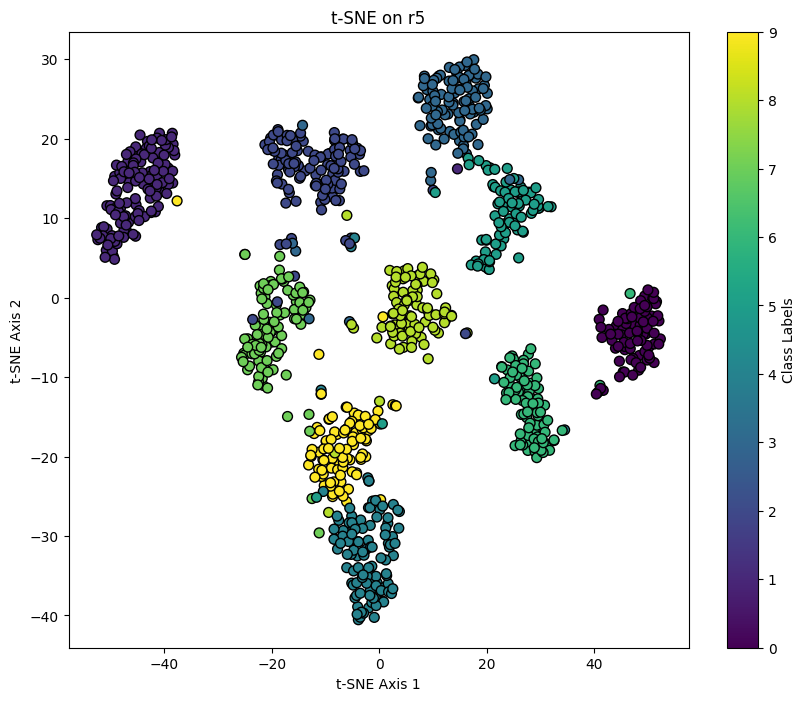

In [24]:
#tsne geometry inspection, NOTE: you will need to flatten the vectors first!!!
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, random_state=0)
'''
Your code here
NOTE: TSNE is a class that has a method fit_transform, so need use tsne.fit_transform
HINT: check examples in documentation
'''
r5_tsne = tsne.fit_transform(r5)

# Visualize the results in a 2D scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(r5_tsne[:, 0], r5_tsne[:, 1], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)
plt.title('t-SNE on r5')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')





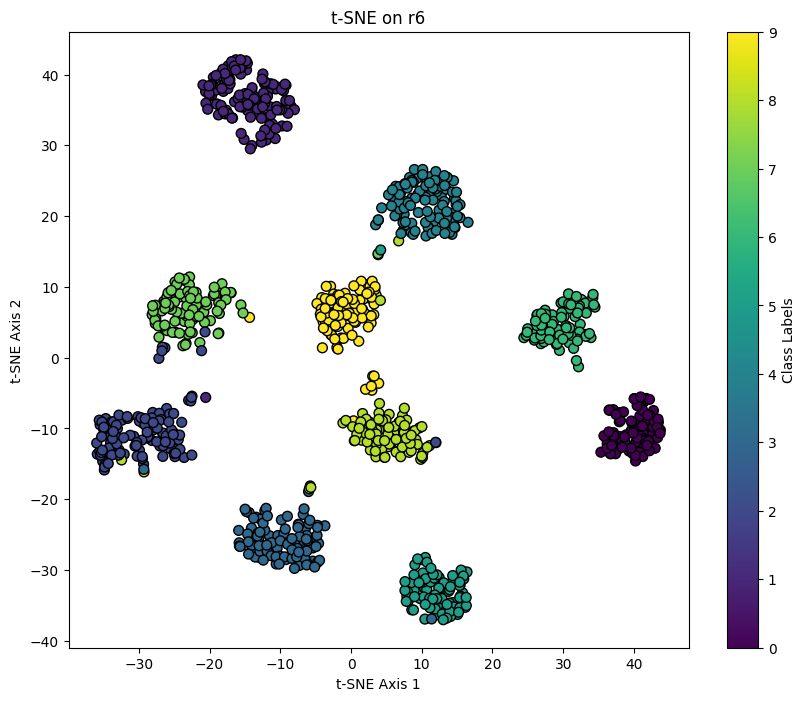

In [25]:
r6_tsne = tsne.fit_transform(r6)

# Visualize the results in a 2D scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(r6_tsne[:, 0], r6_tsne[:, 1], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)
plt.title('t-SNE on r6')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')

In [27]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=51441783eee45c7aac09dcdb2878fda704992f6f370da1daf03fdca2b3af7fc4
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 23.2.1
    Uninstalling pyzmq-23.2.1:
      Successfully uninstalled pyzmq-23.2.1
  Attempting uninstall: ipykerne

In [28]:
#umap geometry inspection
import umap
'''
Your code here
NOTE: similar as above, umap.UMAP has a method fit_transform that you can apply to project your data
HINT: check examples in documentation
'''

'\nYour code here\nNOTE: similar as above, umap.UMAP has a method fit_transform that you can apply to project your data\nHINT: check examples in documentation \n'

In [29]:
reducer = umap.UMAP(random_state=42)
embedding4 = reducer.fit_transform(r4)
embedding5 = reducer.fit_transform(r5)

In [30]:
embedding4.shape

(1000, 2)

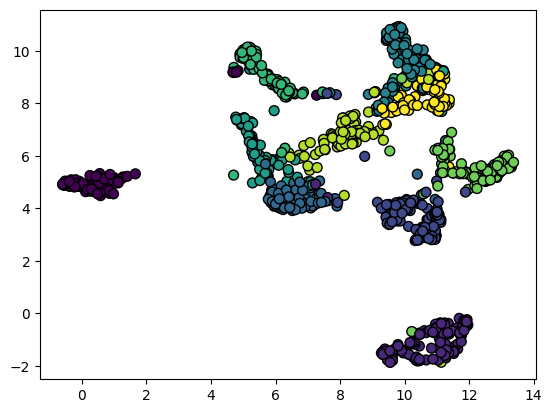

In [31]:
plt.scatter(embedding4[:,0], embedding4[:,1], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')

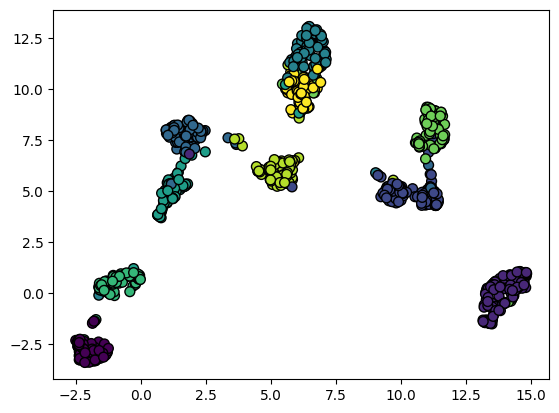

In [32]:
plt.scatter(embedding5[:,0], embedding5[:,1], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)
# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')

Exercise 4: Neihgborhood overlap

Monitoring the geometry of the representations of a dataset in the hidden layers of a DNN can reveal information about the learning procedure (see for instance [Doimo et al., 2020](https://arxiv.org/abs/2007.03506) ).

We consider the Neighborhood Overlap algorithm to compare representations, and to monitor emergence of semantic meaning in various hidden layers. The algorithm only uses the nearest neighbor matrix for some chosen hyperparameter $k$.

Exercise 4.1, compare representations:
- define a function that computes the neighborhood overlap of two representations of the same dataset ($\chi^{l,m}$);
- compute neighborhood overlap for representations extracted in Exercise 1 for the MNIST dataset;
- comment on results.

NOTE: in the function below it is suggested that you start from the matrix of k-NN indices. This is not mandatory, you can implement a version that starts simply from coordinates of points in the two representations.

Enter the value of k for neighborhood calculation: 5


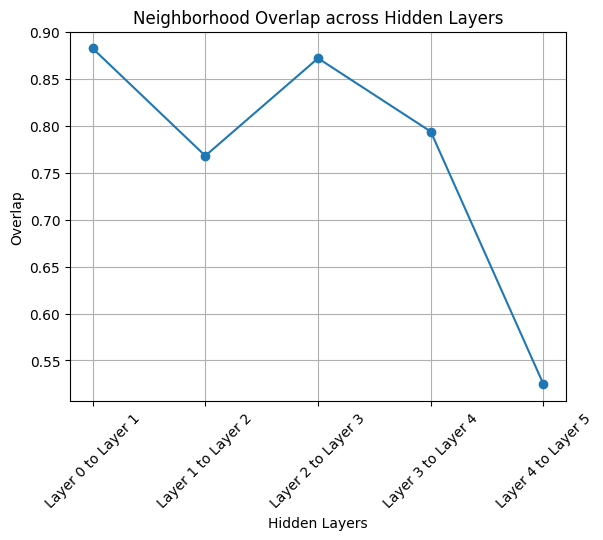

In [39]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

class NeighborhoodOverlap:
    def __init__(self, representations):
        self.representations = [rep.reshape(rep.shape[0], -1) for rep in representations]

    def get_neighbors(self, data, k):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data)
        distances, indices = nbrs.kneighbors(data)
        return indices

    def neig_overlap(self, X, Y, k):
        overlaps = []

        neighbors1 = self.get_neighbors(X, k)
        neighbors2 = self.get_neighbors(Y, k)

        for i in range(len(neighbors1)):
            overlap = len(set(neighbors1[i]).intersection(neighbors2[i])) / k
            overlaps.append(overlap)
        return np.mean(overlaps)

    # def plot_overlaps(self, k):
    #     overlaps = []

    #     for i in range(len(self.representations) - 1):
    #         overlap = self.neig_overlap(self.representations[i], self.representations[i+1], k)
    #         overlaps.append(overlap)

    #     labels = [f"Layer {i} to Layer {i+1}" for i in range(len(overlaps))]

    #     plt.bar(labels, overlaps)
    #     plt.title('Neighborhood Overlaps across Hidden Layers')
    #     plt.xlabel('Hidden Layers')
    #     plt.ylabel('Overlap')
    #     plt.xticks(rotation=45)
    #     plt.show()

    def plot_overlaps(self, k):
        overlaps = []

        for i in range(len(self.representations) - 1):
            overlap = self.neig_overlap(self.representations[i], self.representations[i+1], k)
            overlaps.append(overlap)

        labels = [f"Layer {i} to Layer {i+1}" for i in range(len(overlaps))]

        plt.plot(labels, overlaps, marker='o', linestyle='-')
        plt.title('Neighborhood Overlap across Hidden Layers')
        plt.xlabel('Hidden Layers')
        plt.ylabel('Overlap')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()



# e0, e1, d0, and d1 are already defined as encoder and decoder respectively
representations = [r1, r2, r3 , r4, r5, r6]

# Estimating Neigborhood Overlap across different hidden layers:
k = int(input("Enter the value of k for neighborhood calculation: "))

neighborhood_overlap = NeighborhoodOverlap(representations)
neighborhood_overlap.plot_overlaps(k)


Enter the value of k for neighborhood calculation: 10


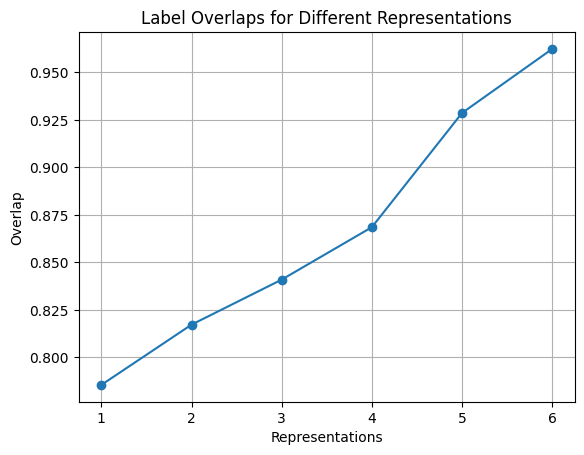

In [35]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

class LabelOverlap:
    def __init__(self, representations, labels):
        self.representations = [rep.reshape(rep.shape[0], -1) for rep in representations]
        self.labels = labels

    def get_neighbors(self, data, k=5):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(data)
        distances, indices = nbrs.kneighbors(data)
        return indices

    def compute_label_overlap(self, indices, k=5):
        cl = [set(np.where(y == i)[0]) for i in self.labels]
        overlaps_gt = 0.0
        for A, B in zip(indices, cl):
            overlaps_gt += len(set(A).intersection(B))
        overlaps_gt = overlaps_gt / (len(indices) * k)
        return overlaps_gt

    def compute_and_print_overlaps(self, k):
        overlaps = []
        for representation in self.representations:
            indices = self.get_neighbors(representation, k)
            overlap = self.compute_label_overlap(indices, k)
            overlaps.append(overlap)

    def plot_overlaps(self, k):
        overlaps = []
        for representation in self.representations:
            indices = self.get_neighbors(representation, k)
            overlap = self.compute_label_overlap(indices, k)
            overlaps.append(overlap)

        plt.plot(range(1, len(self.representations) + 1), overlaps, marker='o')
        plt.title('Label Overlaps for Different Representations')
        plt.xlabel('Representations')
        plt.ylabel('Overlap')
        plt.xticks(range(1, len(self.representations) + 1))
        plt.grid(True)
        plt.show()

representations = [r1, r2, r3, r4, r5, r6]    # encoders = e and decoders = d

label_overlap = LabelOverlap(representations, y)

# Estimating label overlaps for different representations:
k = int(input("Enter the value of k for neighborhood calculation: "))
label_overlap.compute_and_print_overlaps(k)
label_overlap.plot_overlaps(k)


In [ ]:
from sklearn.neighbors import NearestNeighbors

def get_neighbors(X, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    return indices

def neig_overlap(X, Y,k):
    """Computes the neighborhood overlap between two representations.
    Parameters
    ----------
    X : 2D array of ints
        nearest neighbor index matrix of the first representation
    Y : 2D array of ints
        nearest neighbor index matrix of the second representation
    k : int
        number of nearest neighbors used to compute the overlap

    Returns
    -------
    overlap : float
        neighborhood overlap between the two representations
    """
    overlaps = []

    neighbors1 = get_neighbors(X, k)
    neighbors2 = get_neighbors(Y, k)

    for i in range(len(neighbors1)):
        overlap = len(set(neighbors1[i]).intersection(neighbors2[i])) / k
        overlaps.append(overlap)
    return np.mean(overlaps)

# Estimating Neigborhood Overlap across different hidden layers:
k = int(input("Enter the value of k for neighborhood calculation: "))
r1 = r1.reshape(r1.shape[0],-1)
r2 = r2.reshape(r2.shape[0],-1)
r3 = r3.reshape(r3.shape[0],-1)
r4 = r4.reshape(r4.shape[0],-1)
r5 = r5.reshape(r5.shape[0],-1)
r6 = r6.reshape(r5.shape[0],-1)
overlap1 = neig_overlap(r1, r2, k)
overlap2 = neig_overlap(r2, r3, k)
overlap3 = neig_overlap(r3, r4, k)
overlap4 = neig_overlap(r4, r5, k)
overlap5 = neig_overlap(r5, r6, k)

# Print outputs

print(overlap1)
print(overlap2)
print(overlap3)
print(overlap4)
print(overlap5)


0.7677
0.8645000000000003
0.7917000000000001
0.5408999999999998


Exercise 4.2, emergence of semantic:
- define a function that computes the overlap of a representation with given labels ($\chi^{l,\textrm{gt}}$);
- compute alignment with labels for representations extracted in Exercise 1 for the MNIST dataset;
- comment on the results.

NOTE: in the function below it is suggested that you start from the matrix of k-NN indices. This is not mandatory, you can implement a version that starts simply from coordinates of points in the two representations.

In [ ]:
def get_neighbors(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    return indices

def compute_label_overlap(indices, labels, k = 5):
    """Computes the neighborhood overlap with ground truth labels.

    Parameters
    ----------
    indices1 : 2D array (int)
        nearest neighbor index matrix of the first representation
    labels : 1D array (int)
        labels of the datapoints
    k : int
        number of nearest neighbors used to compute the overlap

    Returns
    -------
    overlap : float
        neighborhood overlap with ground truth labels
    """

    # k = int(input("Enter the value of k for neighborhood calculation: "))
    cl = [set(np.where(y == i)[0]) for i in y]
    overlaps_gt = 0.0
    for A, B in zip(indices, cl):
        overlaps_gt += len(set(A).intersection(B))
    overlaps_gt = overlaps_gt/(len(indices)* k)
    return overlaps_gt


r1 = r1.reshape(r1.shape[0],-1)
r2 = r2.reshape(r2.shape[0],-1)
r3 = r3.reshape(r3.shape[0],-1)
r4 = r4.reshape(r4.shape[0],-1)
r5 = r5.reshape(r5.shape[0],-1)
r6 = r6.reshape(r6.shape[0],-1)

indicies_r1 = get_neighbors(r1, k)
indicies_r2 = get_neighbors(r2, k)
indicies_r3 = get_neighbors(r3, k)
indicies_r4 = get_neighbors(r4, k)
indicies_r5 = get_neighbors(r5, k)
indicies_r6 = get_neighbors(r6, k)

overlap_r1 = compute_label_overlap(indicies_r1, y, k)
overlap_r2 = compute_label_overlap(indicies_r2, y, k)
overlap_r3 = compute_label_overlap(indicies_r3, y, k)
overlap_r4 = compute_label_overlap(indicies_r4, y, k)
overlap_r5 = compute_label_overlap(indicies_r5, y, k)
overlap_r6 = compute_label_overlap(indicies_r6, y, k)
print("Overlap of r1 and the Labels, y is :" , overlap_r1)
print("Overlap of r2 and the Labels, y is :" , overlap_r2)
print("Overlap of r3 and the Labels, y is :" , overlap_r3)
print("Overlap of r4 and the Labels, y is :" , overlap_r4)
print("Overlap of r5 and the Labels, y is :" , overlap_r5)
print("Overlap of r6 and the Labels, y is :" , overlap_r6)

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Overlap of r1 and the Labels, y is : 0.7856
Overlap of r2 and the Labels, y is : 0.8173
Overlap of r3 and the Labels, y is : 0.841
Overlap of r4 and the Labels, y is : 0.8684
Overlap of r5 and the Labels, y is : 0.929
Overlap of r6 and the Labels, y is : 0.9627


Exercise 3: Intrinsic dimension

Monitoring the dimension of the representations of a dataset in the hidden layers of a DNN can reveal information about the learning procedure (see for instance [Ansuini et al., 2019](https://proceedings.neurips.cc/paper/2019/file/cfcce0621b49c983991ead4c3d4d3b6b-Paper.pdf) ).

We consider the TWO-NN algorithm for estimating the intrinsic dimension [Facco et al., 2018](https://www.nature.com/articles/s41598-017-11873-y.pdf) of the representations in various hidden layers. The algorithm only uses the distance among the datapoints.

- The ID estimation is as more reliable as more points we consider. Modify the definition of test loader to obtain batches of 5000. Extract representations.
- Start by the input representation of this batch: compute the distance matrix using SciPy [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) and [squareform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html) functions.
- Use the function block_analysis as indicated to compute the decimation curve of ID and the corresponding errors. Plot the results (with error bars).
- Do the same for other hidden representations (I suggest 3,6,7 -why?-). Plot the curves together and discuss the behaviour of the ID in the hidden representations of the model.

In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 12 17:19:48 2018
@author: alessioansuini@gmail.com
"""

import numpy as np
from scipy.stats import pearsonr
from sklearn import linear_model
from math import sqrt
from scipy.spatial.distance import pdist, squareform


def estimate(X,fraction=0.9,verbose=True):
    '''
        Estimates the intrinsic dimension of a system of points from
        the matrix of their distances X

        Args:
        X : 2-D Matrix X (n,n) where n is the number of points
        fraction : fraction of the data considered for the dimensionality
        estimation (default : fraction = 0.9)
        Returns:
        x : log(mu)    (*)
        y : -(1-F(mu)) (*)
        reg : linear regression y ~ x structure obtained with scipy.stats.linregress
        (reg.slope is the intrinsic dimension estimate)
        r : determination coefficient of y ~ x
        pval : p-value of y ~ x

        (*) See cited paper for description

        Usage:

        _,_,reg,r,pval = estimate(X,fraction=0.85)

        The technique is described in :

        "Estimating the intrinsic dimension of datasets by a
        minimal neighborhood information"
        Authors : Elena Facco, Maria d’Errico, Alex Rodriguez & Alessandro Laio
        Scientific Reports 7, Article number: 12140 (2017)
        doi:10.1038/s41598-017-11873-y

    '''

    # sort distance matrix
    Y = np.sort(X,axis=1,kind='quicksort')

    # clean data
    k1 = Y[:,1]
    k2 = Y[:,2]

    zeros = np.where(k1 == 0)[0]
    if verbose:
        print('Found n. {} elements for which r1 = 0'.format(zeros.shape[0]))
        print(zeros)

    degeneracies = np.where(k1 == k2)[0]
    if verbose:
        print('Found n. {} elements for which r1 = r2'.format(degeneracies.shape[0]))
        print(degeneracies)

    good = np.setdiff1d(np.arange(Y.shape[0]), np.array(zeros) )
    good = np.setdiff1d(good,np.array(degeneracies))

    if verbose:
        print('Fraction good points: {}'.format(good.shape[0]/Y.shape[0]))

    k1 = k1[good]
    k2 = k2[good]

    # n.of points to consider for the linear regression
    npoints = int(np.floor(good.shape[0]*fraction))

    # define mu and Femp
    N = good.shape[0]
    mu = np.sort(np.divide(k2, k1), axis=None,kind='quicksort')
    Femp = (np.arange(1,N+1,dtype=np.float64) )/N

    # take logs (leave out the last element because 1-Femp is zero there)
    x = np.log(mu[:-2])
    y = -np.log(1 - Femp[:-2])

    # regression
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(x[0:npoints,np.newaxis],y[0:npoints,np.newaxis])
    r,pval = pearsonr(x[0:npoints], y[0:npoints])
    return x,y,regr.coef_[0][0],r,pval


def block_analysis(X, blocks=list(range(1, 21)), fraction=0.9):

    '''
        Perform a block-analysis of a system of points from
        the matrix of their distances X

        Args:
        X : 2-D Matrix X (n,n) where n is the number of points
        blocks : blocks specification, is a list of integers from
        1 to N_blocks where N_blocks is the number of blocks (default : N_blocks = 20)
        fraction : fraction of the data considered for the dimensionality
        estimation (default : fraction = 0.9)
    '''

    n = X.shape[0]
    dim = np.zeros(len(blocks))
    std = np.zeros(len(blocks))
    n_points = []

    for b in blocks:
        # split indexes array
        idx = np.random.permutation(n)
        npoints = int(np.floor((n / b )))
        idx = idx[0:npoints*b]
        split = np.split(idx,b)
        tdim = np.zeros(b)
        for i in range(b):
            I = np.meshgrid(split[i], split[i], indexing='ij')
            tX = X[tuple(I)]
            _,_,reg,_,_ = estimate(tX,fraction=fraction,verbose=False)
            tdim[i] = reg
        dim[blocks.index(b)] = np.mean(tdim)
        std[blocks.index(b)] = np.std(tdim)
        n_points.append(npoints)
    return dim,std,n_points

In [ ]:
# #import relevant function for ID computation
# from intrinsic_dimension import estimate,block_analysis
# #import relevant function for distance matrix computation
# from scipy.spatial.distance import pdist,squareform

In [41]:
minibatch_size_train = 64
minibatch_size_test = 5000

In [42]:
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST('./data/', transform=transforms,  train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST('./data/', transform=transforms, train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size_test, shuffle=False)


In [43]:
#fix basic training settings, and fix seed. NOTE: modify as you please!
seed = 33
torch.manual_seed(seed)
input_size=(1,28,28,)
epochs=5
lr=0.01
momentum=0.0
log_interval=100

In [44]:
#set up basic train and test functionalities
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

from torchvision.datasets.mnist import read_sn3_pascalvincent_tensor
#define convolutional network with extract method
class ConvNetReps(nn.Module):
    def __init__(self):
        super(ConvNetReps, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def extract(self, x):
        r1 = F.relu(self.conv1(x))
        r2 = F.max_pool2d(r1, 2, 2)
        r3 = F.relu(self.conv2(r2))
        r4 = F.max_pool2d(r3, 2, 2)
        r4 = r4.view(-1, 4*4*50)
        r5 = F.relu(self.fc1(r4))
        r6 = self.fc2(r5)
        return r1, r2, r3, r4 ,r5, r6


In [45]:
model2 =  ConvNetReps().to(device)
summary(model2,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [46]:
model2.eval()
output = model2(inputs.to(device))
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(labels.to(device).view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.084


In [47]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=True
for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

if save:
    torch.save(model.state_dict(),"mnist5000_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.031586
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.097300
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.043867
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.113041
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.031650
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.087534
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.062696
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.058208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.144024
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.055731

Test set: Average loss: 0.0579, Accuracy: 9821/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.023255
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.005675
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.014931
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.037351
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.017953
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.022976
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.117332
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.074250
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.012765
T

In [48]:
#define instance of ConvNetReps(), load weights, set in evaluation mode
model3 = ConvNetReps()

In [49]:
model3.load_state_dict(torch.load('mnist5000_cnn.pt'))

<All keys matched successfully>

In [50]:
#load a batch of inputs from the testloader
#extract representations using method defined above
#inspect dimensions
x_new, y_new = next(iter(testloader))

In [51]:
r1_new, r2_new, r3_new, r4_new, r5_new, r6_new = model3.extract(x_new)

In [52]:
r1_new.size(), r2_new.size(), r3_new.size(), r4_new.size(), r5_new.size(), r6_new.size()

(torch.Size([5000, 20, 24, 24]),
 torch.Size([5000, 20, 12, 12]),
 torch.Size([5000, 50, 8, 8]),
 torch.Size([5000, 800]),
 torch.Size([5000, 500]),
 torch.Size([5000, 10]))

In [53]:
r1_new = r1_new.detach().numpy()
r2_new = r2_new.detach().numpy()
r3_new = r3_new.detach().numpy()
r4_new = r4_new.detach().numpy()
r5_new = r5_new.detach().numpy()
r6_new = r6_new.detach().numpy()

In [54]:
r1_new.shape

(5000, 20, 24, 24)

In [55]:
r1_new = r1_new.reshape(r1_new.shape[0], -1)
r2_new = r2_new.reshape(r2_new.shape[0], -1)
r3_new = r3_new.reshape(r3_new.shape[0], -1)
r4_new = r4_new.reshape(r4_new.shape[0], -1)
r5_new = r5_new.reshape(r5_new.shape[0], -1)
r6_new = r6_new.reshape(r6_new.shape[0], -1)

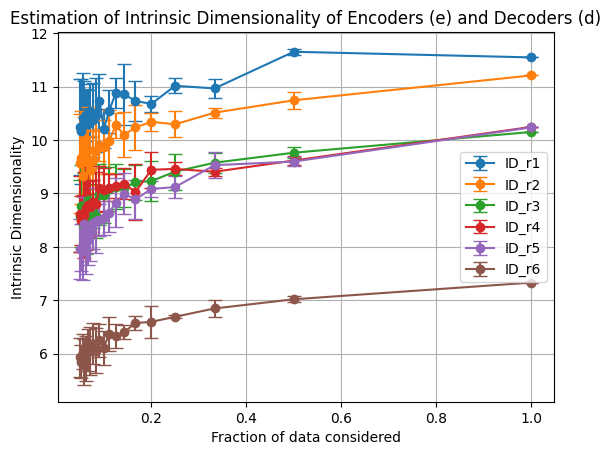

In [56]:
# Generate or load your distance matrix X
dmatrix_r1 = squareform(pdist(r1_new))
dmatrix_r2 = squareform(pdist(r2_new))
dmatrix_r3 = squareform(pdist(r3_new))
dmatrix_r4 = squareform(pdist(r4_new))
dmatrix_r5 = squareform(pdist(r5_new))
dmatrix_r6 = squareform(pdist(r6_new))

# Call block_analysis function to get dimensionality and standard deviation
id_dimensions_r1, std_r1, n_points_r1 = block_analysis(dmatrix_r1)
id_dimensions_r2, std_r2, n_points_r2 = block_analysis(dmatrix_r2)
id_dimensions_r3, std_r3, n_points_r3 = block_analysis(dmatrix_r3)
id_dimensions_r4, std_r4, n_points_r4 = block_analysis(dmatrix_r4)
id_dimensions_r5, std_r5, n_points_r5 = block_analysis(dmatrix_r5)
id_dimensions_r6, std_r6, n_points_r6 = block_analysis(dmatrix_r6)


# Calculate fractions
fractions_r1 = np.array(n_points_r1) / r1_new.shape[0]
fractions_r2 = np.array(n_points_r2) / r2_new.shape[0]
fractions_r3 = np.array(n_points_r3) / r3_new.shape[0]
fractions_r4 = np.array(n_points_r4) / r4_new.shape[0]
fractions_r5 = np.array(n_points_r5) / r5_new.shape[0]
fractions_r6 = np.array(n_points_r6) / r6_new.shape[0]

# Plot
plt.errorbar(fractions_r1, id_dimensions_r1, yerr=std_r1, fmt='o-', capsize=5, label='ID_r1')
plt.errorbar(fractions_r2, id_dimensions_r2, yerr=std_r2, fmt='o-', capsize=5, label='ID_r2')
plt.errorbar(fractions_r3, id_dimensions_r3, yerr=std_r3, fmt='o-', capsize=5, label='ID_r3')
plt.errorbar(fractions_r4, id_dimensions_r4, yerr=std_r4, fmt='o-', capsize=5, label='ID_r4')
plt.errorbar(fractions_r5, id_dimensions_r5, yerr=std_r5, fmt='o-', capsize=5, label='ID_r5')
plt.errorbar(fractions_r6, id_dimensions_r6, yerr=std_r6, fmt='o-', capsize=5, label='ID_r6')

plt.xlabel('Fraction of data considered')
plt.ylabel('Intrinsic Dimensionality')
plt.title('Estimation of Intrinsic Dimensionality of Encoders (e) and Decoders (d)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [ ]:
#compute ID also for layers 3,6,7 and discuss qualitatively the behaviour
'''
Your code here
'''

Extra Exercises:

- Repeat the analysis for the hidden representations of MNIST obtained through your favourite MLP classifier. Compare qualitative the results to the one obtained with CNN.

- Implement neighborhood overlap method and apply it to representations extracted from various layers of our models.